# SIFT BASED SOLUTION


The goal of your project is to release an image retrieval, namely, an algorithm capable to validate/match a given query image in a set of gallery images. You could think it as a kind of image search engine!
In this short tutorial we will have a look to the project for the challenge as described at [link text](https://docs.google.com/document/d/1TqX54BPUi6zVMrJC27xyjhk_zmf03dTX_hRHQf8058w/edit).


# Install and import

First of all, we import the libraries we will use. We do that by using pip (same as Linux shell but you add ! before the command).

In [53]:
!pip install -U opencv-python
!pip uninstall imgaug -y
!pip install imgaug==0.2.5

Found existing installation: imgaug 0.2.5
Uninstalling imgaug-0.2.5:
  Successfully uninstalled imgaug-0.2.5
  Using cached imgaug-0.2.5-py3-none-any.whl


In [54]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.cluster import KMeans
from scipy import spatial
from sklearn.preprocessing import StandardScaler

%matplotlib inline

print("Libraries imported")

Libraries imported


# Dataset class

Let's first define the Dataset class. This class will be used to load classes and image paths.


In [55]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.endswith('.jpg'):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = int(c_name)

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))

    def get_data_paths(self):
        # returns a list of imgpaths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.endswith('.jpg'):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)


    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)

We can now define the validation query and gallery set. First, we get the main data_path.

In [56]:
# we get data_path
data_path = '/content/drive/MyDrive/Classroom/Applied Machine Learning LM Data Science/Challenge/dataset'
data_path = "dataset"

# we define training_path
training_path = os.path.join(data_path, 'training')

# we define validation path, query and gallery
validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')

Finally we init training, gallery and query datasets.

In [57]:
training_dataset = Dataset(data_path=training_path)
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)

Loaded 168 from dataset\training images
Loaded 534 from dataset\validation\gallery images
Loaded 70 from dataset\validation\query images


And we collect query and gallery paths

In [58]:
# get training data and classes
training_paths, training_classes = training_dataset.get_data_paths()

# we get validation gallery and query data

gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()

Let's have a look to some query image

10


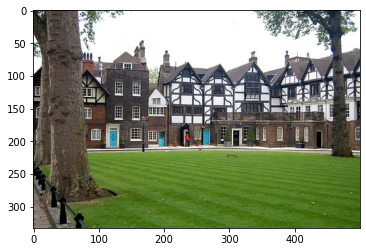

In [59]:
img_query = cv2.imread(query_paths[0])
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)
imshow(img_query)
print(query_classes[0])

10


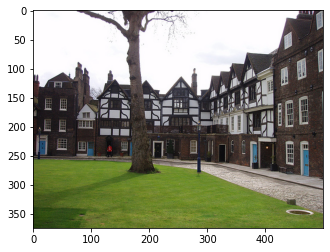

In [60]:
img_gallery = cv2.imread(gallery_paths[0])
img_gallery = cv2.cvtColor(img_gallery, cv2.COLOR_BGR2RGB)
imshow(img_gallery)
print(gallery_classes[0])

# Feature extractor

In our solution we will use scale-invariant feature transform ([SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform)) to extract image fatures. We saw SIFT in our image classification lab, but let's apply them first to some images!

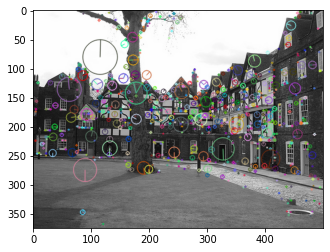

In [61]:
# we init SIFT
sift = cv2.SIFT_create()

# we read a random image
img_rgb = cv2.imread(gallery_paths[0])

# convert to grayscale -> faster, easier to handle, no differences
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# get keypoints and descriptors
kp, descs = sift.detectAndCompute(img_gray, None)

# draw kl
img_sift = cv2.drawKeypoints(img_gray, kp, img_rgb, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(img_sift)

Now that we saw an example of SIFT extraction, let's implement the class we will use to handle the experiment.

We will call it FeatureExtractor

In [62]:
class FeatureExtractor(object):

    def __init__(self, feature_extractor, model, out_dim=20, scale=None, subsample=100):

        # the provided feature extractor
        self.feature_extractor = feature_extractor

        # the clustering model
        self.model = model

        # the scaler -> scale features to the same interval
        self.scale = scale

        # if defined, we collect subsample SIFT desc form each img
        self.subsample = subsample


    def get_descriptor(self, img_path):
        # read image
        img = cv2.imread(img_path)
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # get kp and descriptors, we use descriptors only
        kp, descs = self.feature_extractor.detectAndCompute(img, None)
        return descs


    def fit_model(self, data_list):

        training_feats = []

        # we extact SIFT descriptors
        for img_path in tqdm(data_list, desc='Fit extraction'):
            # we get sift desctiptors for img_path
            descs = self.get_descriptor(img_path)

            # if None == no descriptors we continue
            if descs is None:
                continue
            
            # if subsample, we choose randomly subsample descriptors
            if self.subsample:
                sub_idx = np.random.choice(np.arange(descs.shape[0]), self.subsample)
                descs = descs[sub_idx, :]

            # we append descriptors
            training_feats.append(descs)

        # we concatenate
        training_feats = np.concatenate(training_feats)
        print('--> Model trained on {} features'.format(training_feats.shape))
        
        # we fit the model
        self.model.fit(training_feats)
        print('--> Model fitted')


    def fit_scaler(self, data_list):
        # similar to fit_model
        # we get features mapped from the model
        features = self.extract_features(data_list)
        print('--> Scale trained on {}'.format(features.shape))
        # we fit the scaler
        self.scale.fit(features)
        print('--> Scale fitted')


    def extract_features(self, data_list):
        # we init features
        features = np.zeros((len(data_list), self.model.n_clusters))

        for i, img_path in enumerate(tqdm(data_list, desc='Extraction')):
            # get descriptor
            descs = self.get_descriptor(img_path)
            # 2220x128 descs
            preds = self.model.predict(descs)
            # 2220x1
            histo, _ = np.histogram(preds, bins=np.arange(self.model.n_clusters+1), density=True)
            # append histogram
            features[i, :] = histo

        return features


    def scale_features(self, features):
        # we return the normalized features
        return self.scale.transform(features)

# Build the algorithm

We are now ready to proceed in our algorithm! Let's define SIFT, KMeans clusterer and scaler.

In [63]:
feature_extractor = cv2.SIFT_create()

# we define model for clustering
output_dim = 20
model = KMeans(n_clusters=output_dim, n_init=10, max_iter=5000, verbose=False)
scale = StandardScaler()

# n_init --> number of times the algorithm is executed with different centroids

And finally our FeatureExtractor

In [64]:
# we define the feature extractor providing the model
extractor = FeatureExtractor(feature_extractor=feature_extractor,
                             model=model,
                             scale=scale,
                             out_dim=output_dim)

At this point, we can fit our module. We will use the fit_model() method we defined.

In [65]:
# we fit the KMeans clustering model
extractor.fit_model(training_paths)

Fit extraction: 100%|██████████| 168/168 [00:07<00:00, 21.66it/s]
--> Model trained on (16800, 128) features
--> Model fitted


We do the same with the scaler!

In [66]:
# we fit the scaler
extractor.fit_scaler(training_paths)

Extraction: 100%|██████████| 168/168 [00:09<00:00, 18.54it/s]--> Scale trained on (168, 20)
--> Scale fitted



KMeans and Scaler are now fitted, let's use them to collect query and gallery features

In [67]:
# we get query features
query_features = extractor.extract_features(query_paths)
query_features = extractor.scale_features(query_features)

# we get gallery features
gallery_features = extractor.extract_features(gallery_paths)
gallery_features = extractor.scale_features(gallery_features)

print(gallery_features.shape, query_features.shape)

Extraction: 100%|██████████| 534/534 [00:22<00:00, 23.40it/s](534, 20) (70, 20)



Finally let's compute the pairwise feature distance between query and gallery images

In [68]:
# we use cdis to make it in one pass
# NB: minkowski with p=2 == euclidean distance
pairwise_dist = spatial.distance.cdist(query_features, gallery_features, 'minkowski', p=2.)

print('--> Computed distances and got c-dist {}'.format(pairwise_dist.shape))

# we sort matched indices
indices = np.argsort(pairwise_dist, axis=-1)

--> Computed distances and got c-dist (70, 534)


And here we are, we can sort gallery indices!

In [69]:
gallery_matches = gallery_classes[indices]

In [70]:
pairwise_dist

array([[ 3.89218875,  3.4260025 ,  2.33035077, ...,  4.2722934 ,
         4.70552302,  9.04786049],
       [ 2.81991394,  3.85792263,  3.41517732, ...,  4.77058429,
         4.87376005,  8.49409264],
       [ 3.28660875,  3.39128488,  1.58274242, ...,  3.55976208,
         3.71503714,  8.44462923],
       ...,
       [ 9.16932425,  9.6642316 ,  8.12922078, ...,  7.64713426,
         5.74429501,  8.41384991],
       [ 8.11272552,  8.92872557,  7.21246679, ...,  7.22020688,
         4.80103943, 10.50823799],
       [ 8.08602794,  8.57985509,  7.22253639, ...,  6.95504349,
         4.63367829,  9.23325031]])

In [71]:
len(gallery_matches[0])

534

# Evaluation

As we have query and gallery ground-truth classes, we can check the top-1, top-3 and top-10 accuracy of our method. To do that, we need first to define the top-k accuracy function

In [72]:
def topk_accuracy(gt_label, matched_label, k=1):
    # get top-k matches
    matched_label = matched_label[:, :k]

    # init total and correct
    total = matched_label.shape[0]
    correct = 0
    for q_idx, q_lbl in enumerate(gt_label):
        # if any of the top-k label is correct, increase correct
        correct+= np.any(q_lbl == matched_label[q_idx, :]).item()
    acc_tmp = correct/total

    return acc_tmp

We can now check the accuracy of our algorithm

In [73]:
print('########## RESULTS ##########')

for k in [1, 3, 10]:
    topk_acc = topk_accuracy(query_classes, gallery_matches, k)
    print('--> Top-{:d} Accuracy: {:.3f}'.format(k, topk_acc))

########## RESULTS ##########
--> Top-1 Accuracy: 0.600
--> Top-3 Accuracy: 0.729
--> Top-10 Accuracy: 0.871


Seems to work quite well! What about a random search?

In [74]:
random_indices = np.random.randint(len(gallery_paths),
                                   size=(len(query_paths),len(gallery_paths)))

random_matches = gallery_classes[random_indices]

print('########## RANDOM RESULTS ##########')

for k in [1, 3, 10]:
    topk_acc = topk_accuracy(query_classes, random_matches, k)
    print('--> Top-{:d} Accuracy: {:.3f}'.format(k, topk_acc))

########## RANDOM RESULTS ##########
--> Top-1 Accuracy: 0.000
--> Top-3 Accuracy: 0.043
--> Top-10 Accuracy: 0.186


# Visualization

Let's visualize some results!

This is the first query image

Query class: 11


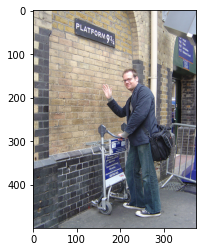

In [75]:
test_image = 8

img_query = cv2.imread(query_paths[test_image])
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)
imshow(img_query)
print('Query class: {}'.format(query_classes[test_image]))

These the matched images

137


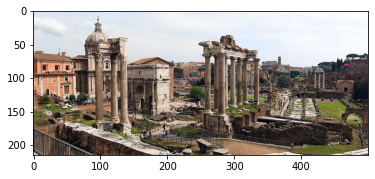

In [76]:
# select a random query
viz_indices = indices[test_image]
top_1 = viz_indices[0]

print(top_1)

img_match = cv2.imread(gallery_paths[top_1])
img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
plt.imshow(img_match)

Thanks for the attention!

<Figure size 1440x1872 with 0 Axes>

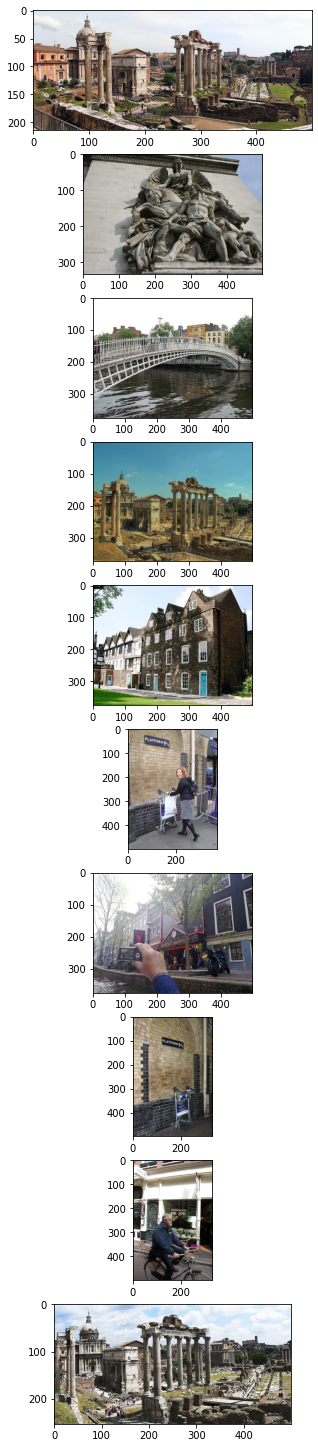

In [77]:
plt.rcParams['figure.figsize'] = [20, 26]

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(10, 1) 

for i in range(10):

    # select a random query
    viz_indices = indices[test_image]
    top_1 = viz_indices[i]

    img_match = cv2.imread(gallery_paths[top_1])
    img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_match)

    axarr[i].imshow(img_match)



In [78]:
indices[29]

array([ 69,  82,   9, 446,  62, 489, 130,  95, 257, 397,  59, 234, 369,
       136,  76,  79, 129,  65,  67,  83,  72,  63,  60, 443, 483,  75,
        70,  68, 137, 147,  90, 132, 139, 304, 133,  80, 380, 190, 148,
        98, 155, 204, 378, 454, 192,  73, 524,  23,  61, 528, 214, 280,
       229, 131, 449, 367, 444,  18, 211, 134,   4,  21, 292, 320, 288,
        96, 182, 389, 306, 298,  85, 316,  77, 233, 231, 200, 425, 268,
       207, 225,  17, 291, 490,  99,  92, 330, 326, 482, 297,  22,   2,
        26,  25, 128, 286, 314,  42, 461, 523, 392,  64, 479,  71, 408,
        38, 514, 241,   7,  32, 398,  43, 532, 368, 527, 509, 458, 497,
        87, 285,  20,  94, 115, 169, 227, 284, 357,  24,  74, 526,  13,
        84, 212,  97,  91, 293, 167, 531,  34, 445, 265,  12, 168, 505,
       339, 407, 264, 239,  11, 135, 208, 218, 278, 219, 138, 429, 351,
       301,  88, 353, 272,  19, 395, 345, 520, 180,  41,  89, 496, 419,
       437, 312, 464, 440, 396, 246, 145, 459, 315, 506, 393, 51